<a href="https://colab.research.google.com/github/Joha1262/Pneumonia-Disease-using-MobileNet-Random-Forest/blob/main/Skin_Cancer_Detection_using_MobileNet_%2B_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Step 1: Setup & Dataset Download

import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [17]:
# Step 2: Image Data Preprocessing (Fixed)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "/root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1"
data_root = os.path.join(base_dir, "Skin cancer ISIC The International Skin Imaging Collaboration")

train_dir = os.path.join(data_root, "Train")
val_dir = os.path.join(data_root, "Test")  # sometimes called 'Test' or 'Validation'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

print(" Fixed paths — data generators ready!")


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
 Fixed paths — data generators ready!


In [18]:
# Step 3A: Train Image Model (Skin Cancer Classification)

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 (exclude top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False   # freeze convolutional base

# Build new classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

cnn_model = Model(inputs=base_model.input, outputs=output)

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train
history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,     # increase to 10-20 for best accuracy
    verbose=1
)

cnn_model.save("image_model.h5")
print("Image model trained and saved as image_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.2885 - loss: 2.0214 - val_accuracy: 0.2881 - val_loss: 1.8875
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4230 - loss: 1.5581 - val_accuracy: 0.3390 - val_loss: 1.8226
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4856 - loss: 1.4423 - val_accuracy: 0.3898 - val_loss: 1.7344
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4938 - loss: 1.4065 - val_accuracy: 0.3390 - val_loss: 1.9134
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5288 - loss: 1.3319 - val_accuracy: 0.3814 - val_loss: 1.8258


Image model trained and saved as image_model.h5


In [19]:
# Step 3B: Tabular Model (Random Forest) with Synthetic Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Generate synthetic tabular dataset
np.random.seed(42)
df = pd.DataFrame({
    "Age": np.random.randint(20, 80, 500),           # Patient age
    "Lesion_Size": np.random.rand(500)*5,            # Lesion size in cm
    "Itching": np.random.randint(0, 2, 500),         # 0=No, 1=Yes
    "Pain": np.random.randint(0, 2, 500),            # 0=No, 1=Yes
    "Disease": np.random.randint(0, 9, 500)          # 9 classes of skin cancer
})

df.head()


,Age,Lesion_Size,Itching,Pain,Disease
0,58,2.556712,0,0,5
1,71,2.507581,1,0,2
2,48,3.991476,0,1,7
3,34,3.249820,0,0,8
4,62,3.509834,0,1,0


In [20]:
#  Split features and target ---
X = df[["Age", "Lesion_Size", "Itching", "Pain"]]
y = df["Disease"]

#  Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train Random Forest ---
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

#  Save model & scaler ---
joblib.dump(rf_model, "tabular_model.pkl")
joblib.dump(scaler, "preprocessor.pkl")

print(" Tabular model trained and saved!")


 Tabular model trained and saved!


3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
 Image Model Confusion Matrix:
 [[ 0  1  0  2  4  8  0  0  1]
 [ 0  3  1  2  3  7  0  0  0]
 [ 0  2  0  5  2  5  0  1  1]
 [ 1  1  2  1  2  8  0  0  1]
 [ 0  1  0  1  2 12  0  0  0]
 [ 1  0  0  2  6  7  0  0  0]
 [ 0  0  0  0  0  1  0  2  0]
 [ 0  0  1  3  4  6  0  2  0]
 [ 0  1  0  0  0  2  0  0  0]]
 Image Model Classification Report:
                             precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.33      0.19      0.24        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.06      0.06      0.06        16
                     nevus       0.09      0.12      0.10        16
pigmented benign keratosis       0.12      0.44      0.19        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.40      0.12      0.19        16
           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


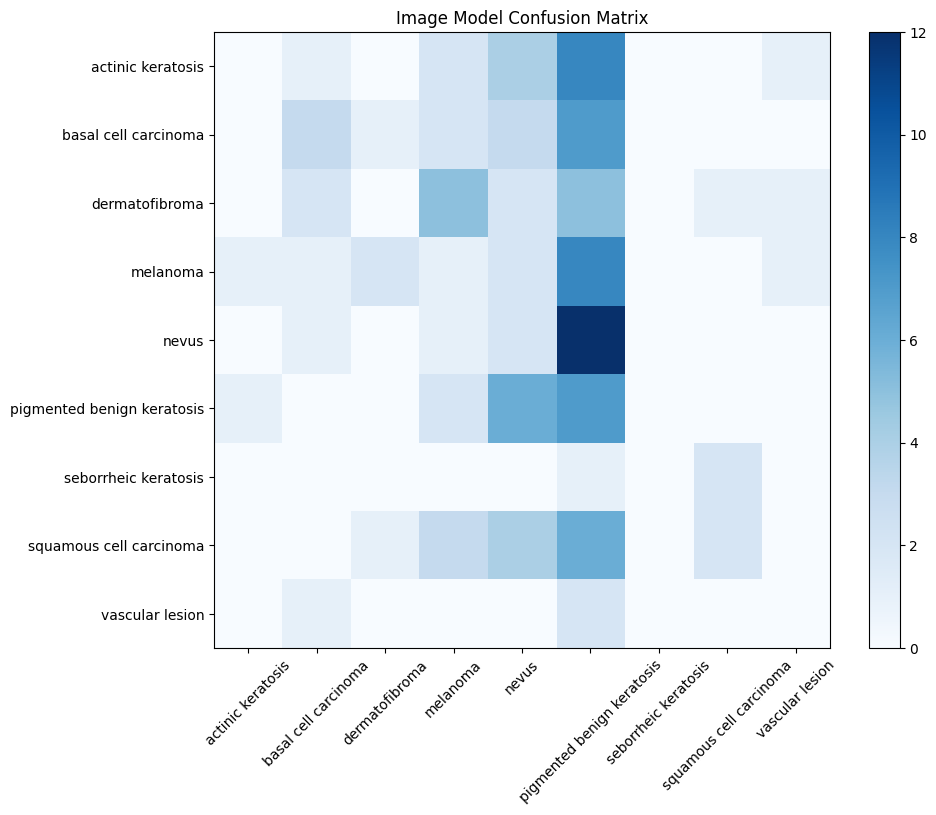

In [21]:
# Step 4A: Evaluate Image Model

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict on validation set
val_steps = val_data.samples // val_data.batch_size + 1
pred_probs = cnn_model.predict(val_data, steps=val_steps)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(" Image Model Confusion Matrix:\n", cm)

# Classification Report
labels = list(val_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=labels)
print(" Image Model Classification Report:\n", report)

# Optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Blues')
plt.title("Image Model Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.show()


 Tabular Model Evaluation:
Accuracy:  13.00%
Precision: 15.71%
Recall:    13.00%
F1 Score:  13.58%
Confusion Matrix:
 [[2 1 1 0 2 2 1 0 1]
 [2 2 4 2 1 1 1 2 1]
 [2 2 1 1 1 2 1 1 0]
 [2 1 0 2 3 1 2 0 1]
 [1 0 2 0 2 2 2 0 1]
 [4 0 0 3 1 1 3 1 1]
 [2 0 2 0 2 1 0 0 0]
 [0 2 1 3 1 2 1 2 1]
 [1 1 2 0 0 2 0 0 1]]


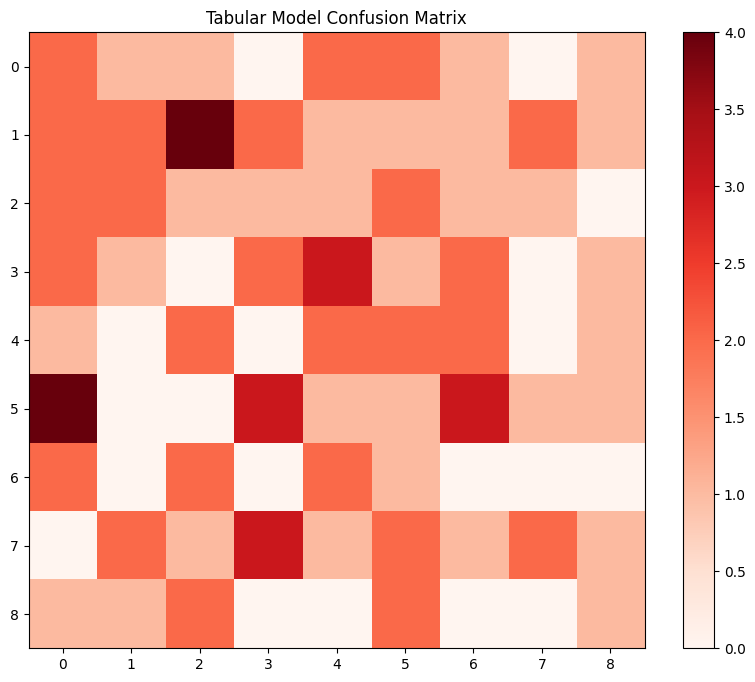

In [22]:
# Step 4B: Evaluate Tabular Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on test set
y_pred_tab = rf_model.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred_tab)
precision = precision_score(y_test, y_pred_tab, average='weighted')
recall = recall_score(y_test, y_pred_tab, average='weighted')
f1 = f1_score(y_test, y_pred_tab, average='weighted')

print(" Tabular Model Evaluation:")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")

# Confusion Matrix
cm_tab = confusion_matrix(y_test, y_pred_tab)
print("Confusion Matrix:\n", cm_tab)

# Optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm_tab, cmap='Reds')
plt.title("Tabular Model Confusion Matrix")
plt.colorbar()
plt.show()


In [26]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import joblib
import tensorflow as tf

# Load trained models
cnn_model = tf.keras.models.load_model("image_model.h5")
rf_model = joblib.load("tabular_model.pkl")
scaler = joblib.load("preprocessor.pkl")

# Define class mapping (9 skin cancer classes)
class_mapping = {
    0: "Melanoma",
    1: "Basal Cell Carcinoma",
    2: "Actinic Keratosis",
    3: "Benign Keratosis",
    4: "Dermatofibroma",
    5: "Vascular Lesion",
    6: "Squamous Cell Carcinoma",
    7: "Nevus",
    8: "Seborrheic Keratosis"
}

#  Upload skin lesion image
print("Upload a skin lesion image (JPEG/PNG):")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

#  Collect tabular input from user
age = float(input("Enter Age: "))
lesion_size = float(input("Lesion Size (0-5 cm): "))
itching = int(input("Itching? (1=Yes, 0=No): "))
pain = int(input("Pain? (1=Yes, 0=No): "))

# Image prediction
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)
img_probs = cnn_model.predict(img_array)[0]  # probabilities for 9 classes
img_pred = np.argmax(img_probs)
img_conf = img_probs[img_pred]

#  Tabular prediction
tab_features = np.array([[age, lesion_size, itching, pain]])
tab_scaled = scaler.transform(tab_features)
tab_probs = rf_model.predict_proba(tab_scaled)[0]  # probabilities for
tab_pred = np.argmax(tab_probs)
tab_conf = tab_probs[tab_pred]

# Combine predictions
combined_probs = (img_probs + tab_probs) / 2
final_pred = np.argmax(combined_probs)
final_conf = combined_probs[final_pred]

# Print nicely
print("\n Final Prediction Results:")
print(f"Image Model Prediction: {class_mapping[img_pred]} ({img_conf*100:.2f}% confidence)")
print(f"Tabular Model Prediction: {class_mapping[tab_pred]} ({tab_conf*100:.2f}% confidence)")
print(f" Combined Final Prediction: {class_mapping[final_pred]} ({final_conf*100:.2f}% confidence)")


Upload a skin lesion image (JPEG/PNG):


Saving ISIC_0024331.jpg to ISIC_0024331 (3).jpg
Enter Age: 60
Lesion Size (0-5 cm): 4
Itching? (1=Yes, 0=No): 1
Pain? (1=Yes, 0=No): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step

 Final Prediction Results:
Image Model Prediction: Basal Cell Carcinoma (34.53% confidence)
Tabular Model Prediction: Vascular Lesion (23.50% confidence)
 Combined Final Prediction: Vascular Lesion (22.71% confidence)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
